## Parsing Mini-EUSO log files

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime
from datetime import date, time

In [105]:
filename = 'test_data/CPU_MAIN__2020_03_02__18_34_22.log'
search_str = 'average photodiode reading is:'
day_str = 'entering DAY mode'
night_str = 'entering NIGHT mode'

In [106]:
# Set date
my_day = date(2020, 3, 2)

In [107]:
# Grab photodiode read logs, ignoring ones that get cut off
lines = [line.rstrip('\n') for line in open(filename) if 
         ((search_str in line) and (len(line) > 65))]

# Grab DAY/NIGHT siwtching times
day_lines = [line.rstrip('\n') for line in open(filename) if 
             day_str in line and len(line) > 49]
night_lines = [line.rstrip('\n') for line in open(filename) if 
               (night_str in line and len(line)>26)]

In [108]:
l = lines[0]
start = l.find(search_str)

In [109]:
l = night_lines[0]
start = l.find(search_str)
ts = l[start-40:start-25]

In [126]:
# loop through and parse details (timestamp and photodiode value)
day = []
timestamp = []
photodiode = []
for l in lines:
    start = l.find(search_str)
    day.append(date(int(l[start-33:start-29]), 
                    int(l[start-28:start-26]), 
                    int(l[start-25:start-23])))
    ts = l[start-22:start-7]
    timestamp.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                          second=int(ts[6:8]), microsecond=int(ts[9:15])))
    photodiode.append(float(l[start+31:start+34]))

# Combine day and timestamp
x_dt = [ datetime.datetime.combine(d, t) for d, t in zip(day, timestamp) ]

In [127]:
# Parse switching times
day = []
day_switch = []
for l in day_lines:
    start = l.find(search_str)
    day.append(date(int(l[start-49:start-45]), 
                   int(l[start-44:start-42]), 
                   int(l[start-41:start-39])))
    ts = l[start-38:start-23]
    day_switch.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                              second=int(ts[6:8]), microsecond=int(ts[9:15])))
x_day = [ datetime.datetime.combine(d, t) for d, t in zip(day, day_switch) ]

day = []
night_switch = []
for l in night_lines:
    start = l.find(search_str)
    day.append(datetime.date(int(l[start-51:start-47]), 
                             int(l[start-46:start-44]), 
                             int(l[start-43:start-41])))
    ts = l[start-40:start-25]
    night_switch.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                              second=int(ts[6:8]), microsecond=int(ts[9:15])))

x_night = [ datetime.datetime.combine(d, t) for d, t in zip(day, night_switch) ]

## Plot results

In [128]:
plt.style.use('minimalist')

In [129]:
# FIX: add automatic correction of cutoff timestamps
cut_off_day = []
cut_off_day.append(datetime.datetime(year=2020, month=3, day=2, 
                                     hour=19, minute=16, second=11, 
                                     microsecond=998299))
cut_off_day.append(datetime.datetime(year=2020, month=3, day=2, 
                                     hour=21, minute=3, second=25, 
                                     microsecond=159827))
cut_off_day.append(datetime.datetime(year=2020, month=3, day=3, 
                                     hour=3, minute=0, second=14, 
                                     microsecond=493104))

In [130]:
from scipy.ndimage import gaussian_filter

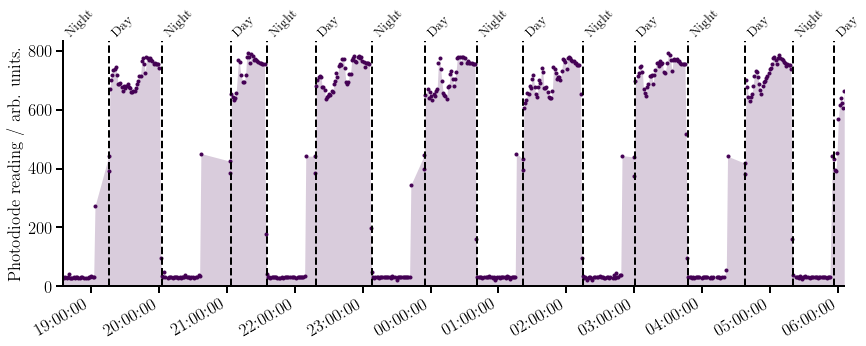

In [161]:
fig, ax = plt.subplots()
fig.set_size_inches((14, 5))
ax.plot(x_dt, photodiode, 'o', color=plt.cm.viridis(0), markersize=3, alpha=1)
#ax.plot(x_dt, photodiode, alpha=0.7, color=plt.cm.viridis(0), lw=2)
ax.fill_between(x_dt, photodiode, np.tile(0, len(photodiode)), 
                alpha=0.2, color=plt.cm.viridis(0), lw=0)
for d in np.array(x_day)[np.array([0, 1, 2, 5, 8])]:
    ax.axvline(d, color='k', linestyle='--', lw=2)
    ax.text(d, 850, 'Day', rotation=45)
for d in cut_off_day:
    ax.axvline(d, color='k', linestyle='--', lw=2)
    ax.text(d, 850, 'Day', rotation=45)
for n in x_night:
    ax.axvline(n, color='k', linestyle='--', lw=2)
    ax.text(n, 850, 'Night', rotation=45)
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
#ax.set_xlabel('Timestamp (hour:min:sec)')
ax.set_ylabel('Photodiode reading / arb. units.')
ax.set_xlim(x_dt[0])
ax.set_ylim(0)
fig.savefig('figures/log_parsing.pdf', dpi=500, bbox_inches='tight')

## Time between photodiode readings

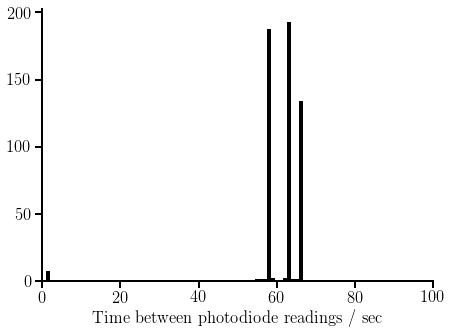

In [162]:
delta_t = np.array(x_dt[1:]) - np.array(x_dt[0:-1])
delta_t = [_.seconds for _ in delta_t]

fig, ax = plt.subplots()
ax.hist(delta_t, bins=np.linspace(0, 100, 100));
ax.set_xlabel('Time between photodiode readings / sec')
fig.savefig('figures/photodiode_time_hist.pdf', dpi=500, bbox_inches='tight')

In [163]:
np.mean(delta_t)

72.7886323268206